In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')


In [3]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [4]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-07-26,0,0,0,0,0,שלילי,No,זכר,Other
1,2020-07-26,0,0,0,0,0,שלילי,No,נקבה,Other
2,2020-07-26,0,0,0,0,0,שלילי,No,זכר,Other
3,2020-07-26,0,0,0,0,0,שלילי,No,זכר,Other
4,2020-07-26,0,0,0,0,0,שלילי,No,נקבה,Other


In [5]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [6]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [7]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [8]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,No,NaT
1,2020-03-18,2020-03-18,חיובי,1,No,NaT
2,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
3,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
4,2020-03-20,2020-03-20,שלילי,4,Yes,NaT


In [9]:
bdi.shape

(1643764, 6)

In [10]:
bdi.corona_result.value_counts()

שלילי               1513954
חיובי                 97406
לא בוצע/פסול 999      18536
חיובי גבולי           12873
בעבודה                  597
לא ודאי                 398
Name: corona_result, dtype: int64

In [11]:
niv.corona_result.value_counts()

שלילי    1060744
חיובי      53878
אחר        14285
Name: corona_result, dtype: int64

In [12]:
niv.test_indication.value_counts()

Other                     1065932
Contact with confirmed      34890
Abroad                      28085
Name: test_indication, dtype: int64

In [13]:
niv.age_60_and_above.value_counts()

No     561116
Yes     82642
Name: age_60_and_above, dtype: int64

In [14]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [15]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [16]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [17]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [18]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,6,6,17,12.833333,13,12
1,3,11061,2,112,16.665582,17,33183
2,4,5081,2,114,21.462114,21,20324
3,5,3127,2,106,24.647905,25,15635
4,6,1786,6,96,27.668533,27,10716
5,7,1063,8,108,30.398871,30,7441
6,8,597,3,103,33.475712,33,4776
7,9,357,3,78,35.700280,35,3213
8,10,573,5,106,41.130890,41,5730


In [19]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
9432,114,4,60+,זכר,Other
12342,112,3,30-39,זכר,Contact with confirmed
9304,111,4,20-29,זכר,Other
1600,108,7,40-49,נקבה,Contact with confirmed
6311,106,5,30-39,זכר,Contact with confirmed
23175,106,10+,0-19,נקבה,Contact with confirmed
9696,105,4,30-39,נקבה,Other
456,103,8,50-59,נקבה,Contact with confirmed
20936,103,3,0-19,זכר,Abroad
23273,100,10+,60+,זכר,Contact with confirmed


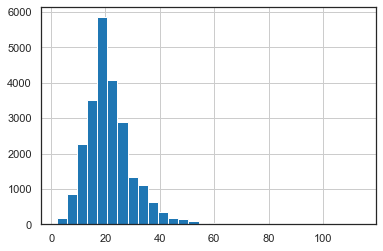

In [20]:
rec.days_between_pos_and_neg.hist(bins=30)

In [21]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-07-25,42769,8445,3470,380
1,2020-07-24,42849,8441,4603,587
2,2020-07-23,42364,8427,6215,701
3,2020-07-22,42589,8426,6806,753
4,2020-07-21,42446,8310,6223,669


In [22]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [23]:
niv.age_60_and_above.value_counts()

No     561116
Yes     82642
Name: age_60_and_above, dtype: int64

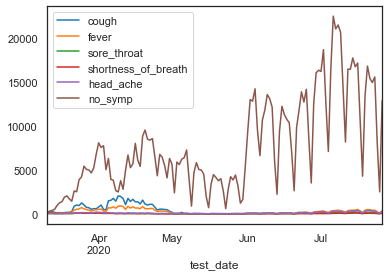

In [24]:
niv.groupby('test_date')[symptom_cols].sum().plot()

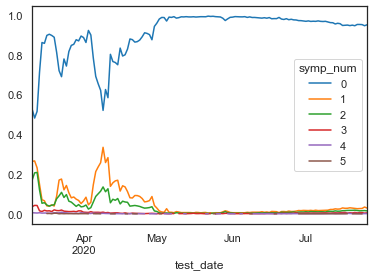

In [25]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

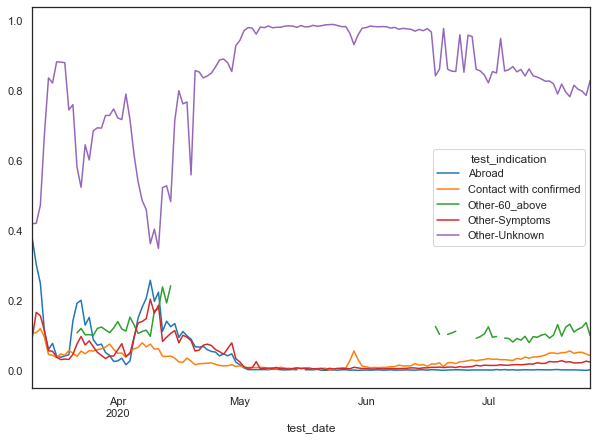

In [26]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

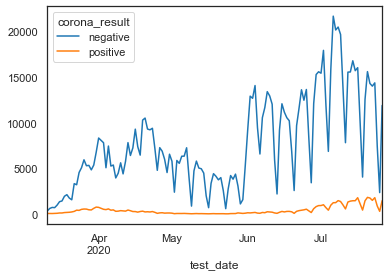

In [27]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [28]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

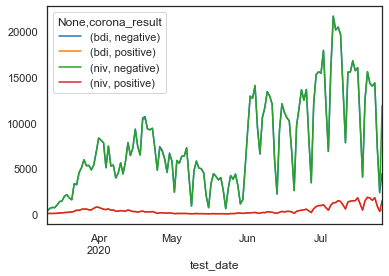

In [29]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

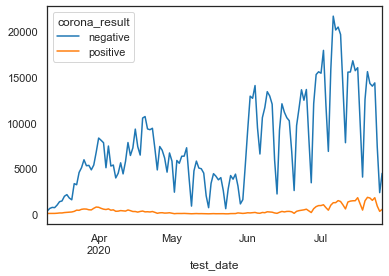

In [30]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [31]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,3,3
2020-03-12,20,6
2020-03-13,17,2
2020-03-14,25,3
2020-03-15,70,45
...,...,...
2020-07-22,12952,1491
2020-07-23,13944,992
2020-07-24,5348,451


In [32]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,36.0,NaN,2375.0,18.0,NaN
2020-05-08,27.0,NaN,3947.0,18.0,NaN
2020-05-09,31.0,NaN,849.0,9.0,NaN
2020-05-12,46.0,NaN,5021.0,19.0,NaN
2020-05-14,60.0,1.0,4469.0,16.0,NaN
2020-05-15,28.0,NaN,1979.0,7.0,NaN
2020-05-16,24.0,NaN,675.0,4.0,NaN
2020-05-17,59.0,NaN,3341.0,15.0,NaN
2020-05-19,32.0,NaN,4124.0,12.0,NaN


In [33]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-07-22,174.0,NaN,14003.0,1481.0,NaN
2020-07-23,183.0,NaN,14364.0,1771.0,NaN
2020-07-24,116.0,NaN,7369.0,859.0,NaN
2020-07-25,28.0,NaN,2325.0,274.0,NaN
2020-07-26,75.0,NaN,4444.0,493.0,NaN


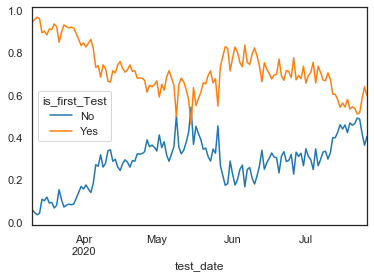

In [34]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

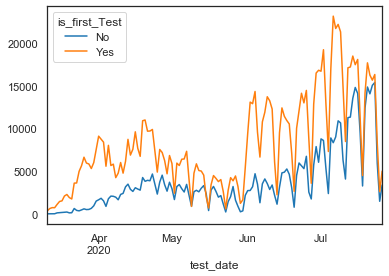

In [35]:
ti.plot()

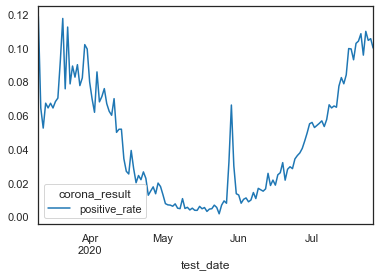

In [36]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [37]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-07-22,15050,15658
2020-07-23,15383,16318
2020-07-24,5958,8344
2020-07-25,1488,2627
2020-07-26,3388,5012


In [38]:
ti.Yes.sum() + ti.No.sum()

1643764

In [39]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [40]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [41]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [42]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [43]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,75,36.0,48.0,17.4,15,20.0,63.0,15.3,68,...,47.0,16.8,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,97,39.2,50.0,18.0,15,20.0,63.0,15.3,90,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,115,39.1,49.0,18.0,15,20.0,63.0,15.3,105,...,47.0,17.4,15,50.0,64.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,153,41.2,47.0,18.3,15,0.0,70.0,7.4,144,...,46.0,17.5,15,50.0,64.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,192,44.3,46.0,18.6,15,20.0,74.0,7.6,178,...,45.0,17.6,15,50.0,58.0,14.9,15,37.5,79.0,9.1


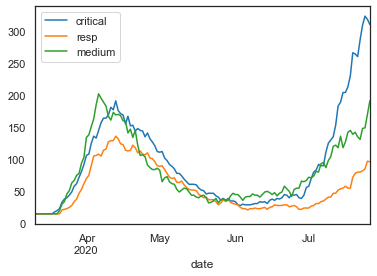

In [44]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [45]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,319,43,0.118785
1,2020-03-12,15,15,15,597,41,0.064263
2,2020-03-13,15,15,15,706,39,0.052349
3,2020-03-14,15,15,15,681,49,0.067123
4,2020-03-15,15,15,15,960,66,0.064327


In [46]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [47]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


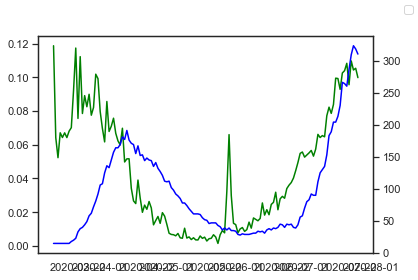

In [48]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [49]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [50]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [51]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

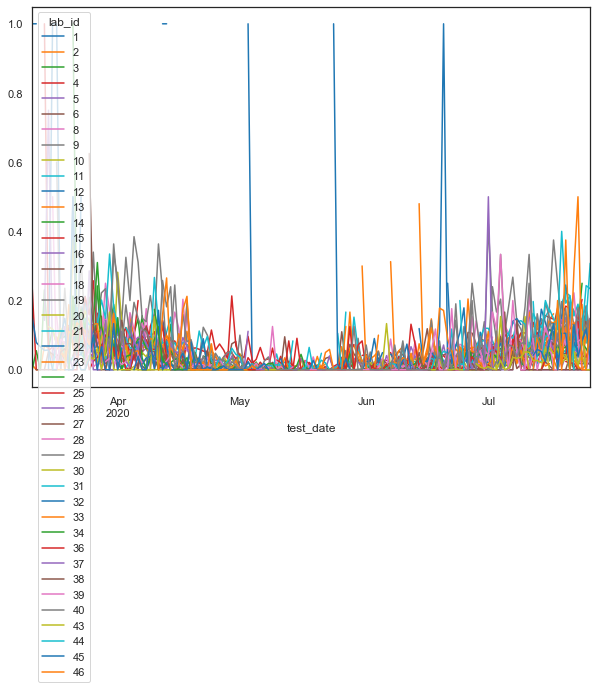

In [52]:
polab = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative)
polab.positive_rate.unstack().plot(figsize=(10,7))

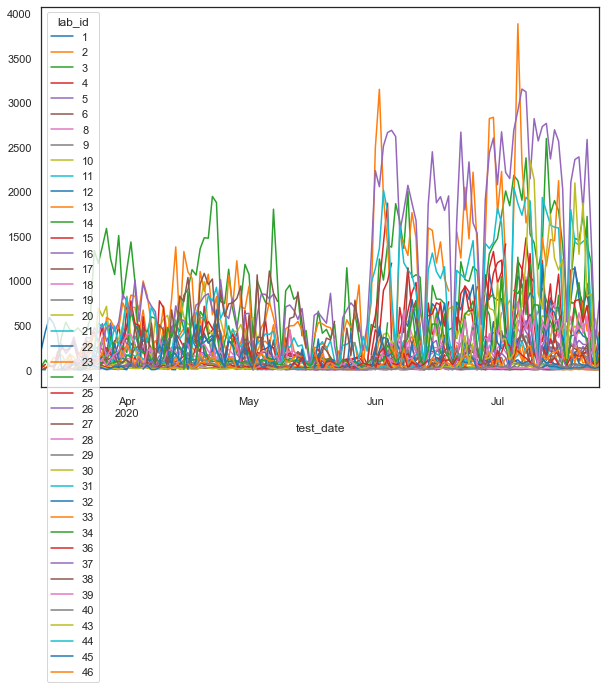

In [53]:
polab.total_tests.unstack().plot(figsize=(10,7))

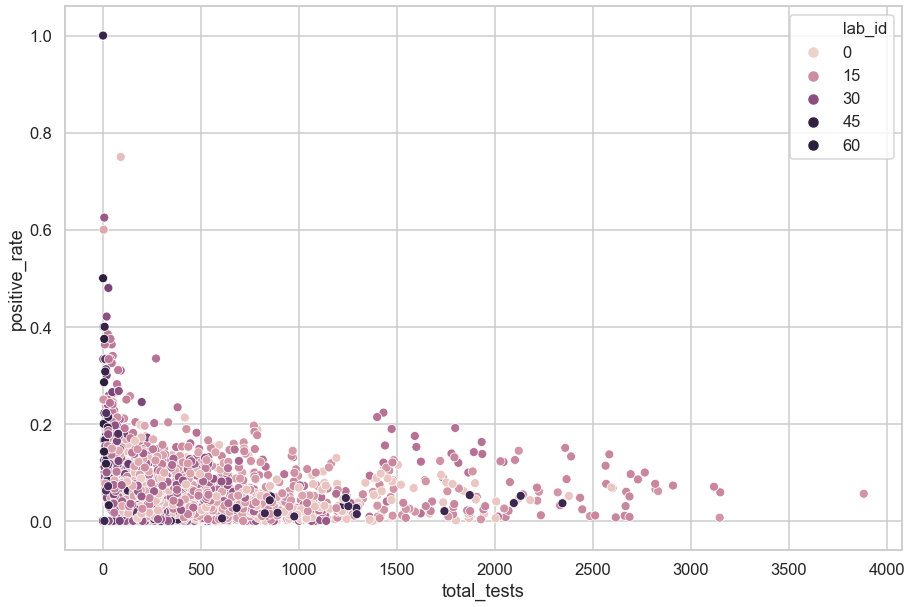

In [101]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [102]:
import altair as alt

In [109]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [54]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result,positive,negative,total_tests,positive_rate
lab_id,,,,
16,8275.0,145469.0,154221.0,2.8
3,5424.0,122005.0,128560.0,2.2
13,5366.0,105344.0,113820.0,2.5
21,7404.0,81556.0,89377.0,4.5
4,2128.0,53716.0,56490.0,2.0
10,2273.0,50487.0,54008.0,2.3
15,3617.0,47412.0,51570.0,3.8
12,2074.0,40569.0,43429.0,2.6
14,1299.0,37656.0,39205.0,1.7


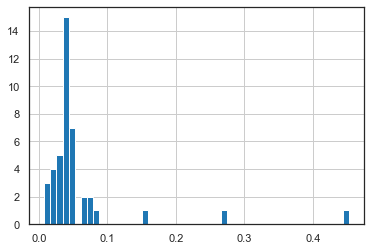

In [55]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [91]:
top_5_labs = bdi[bdi.is_first_Test=='Yes'].lab_id.value_counts().index[:5]
top_5_labs

Int64Index([16, 3, 13, 21, 4], dtype='int64')

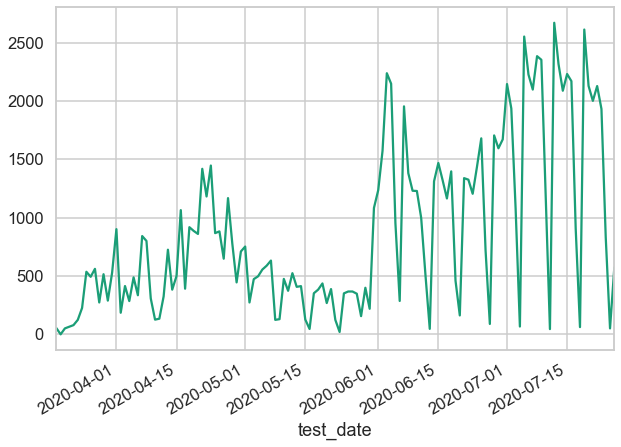

In [92]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

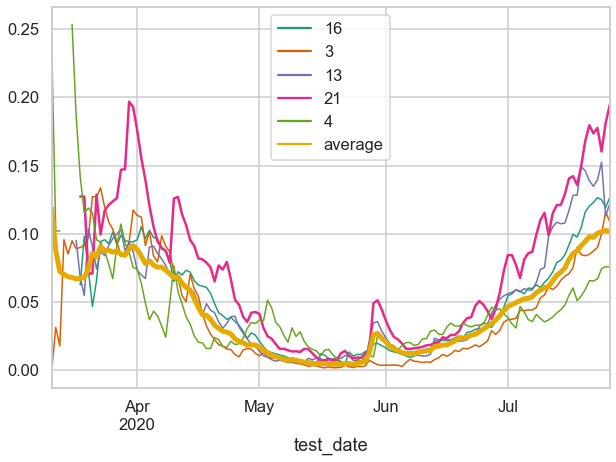

In [95]:
sns.set_palette(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=[1.5,1.5,1.5,2.5,1.5,5][i])


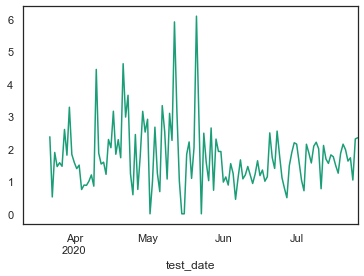

In [59]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [60]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06965355123971567

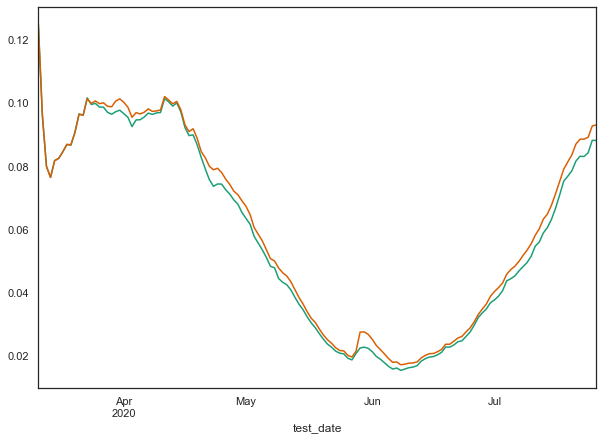

In [61]:
ax = (bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

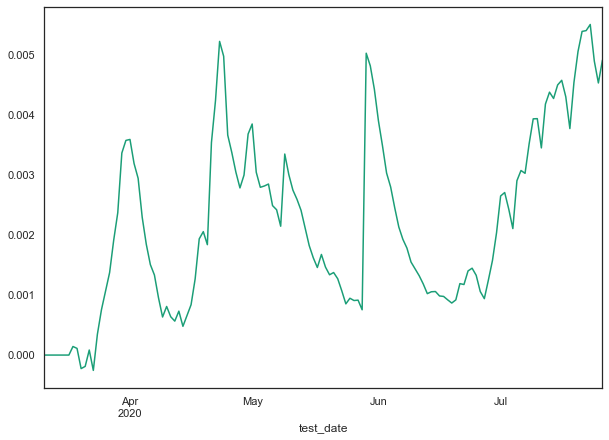

In [62]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

## Decseased 

In [63]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11)
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 1.0]    0.142857
(1.0, 3.0]       0.078891
(3.0, 4.727]     0.046908
(4.727, 6.0]     0.113006
(6.0, 8.0]       0.098081
(8.0, 9.0]       0.061834
(9.0, 12.0]      0.115139
(12.0, 15.0]     0.072495
(15.0, 21.0]     0.078891
(21.0, 31.0]     0.089552
(31.0, 107.0]    0.087420
Name: qc, dtype: float64

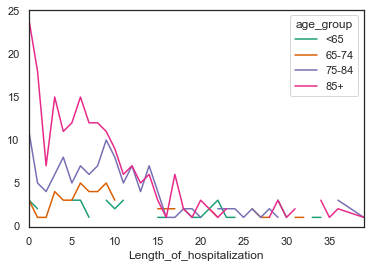

In [64]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

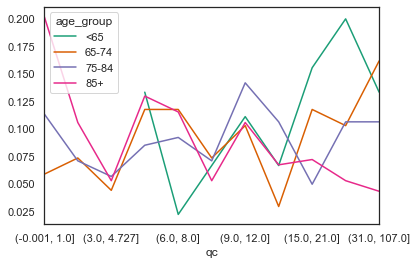

In [65]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [66]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.087420
1.0    0.055437
2.0    0.025586
3.0    0.053305
4.0    0.046908
5.0    0.049041
6.0    0.063966
7.0    0.049041
8.0    0.049041
9.0    0.061834
Name: Length_of_hospitalization, dtype: float64

In [67]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-36.0    0.002132
-21.0    0.002132
-15.0    0.002132
-14.0    0.002132
-9.0     0.002132
-8.0     0.002132
-6.0     0.002132
-5.0     0.002132
-4.0     0.006397
-3.0     0.004264
Name: Time_between_positive_and_hospitalization, dtype: float64

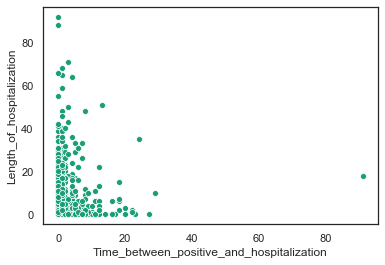

In [68]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

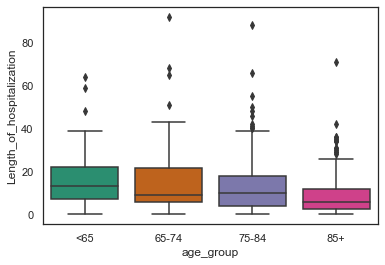

In [69]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [70]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

,gender,age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death,time,file
0,זכר,<65,1.0,2.0,20.0,22,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
203,נקבה,75-84,1.0,0.0,12.0,12,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
202,נקבה,85+,0.0,10.0,1.0,11,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
201,נקבה,85+,0.0,2.0,17.0,19,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
200,זכר,85+,1.0,0.0,9.0,9,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz


In [71]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((4589, 8), (427, 8))

In [72]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

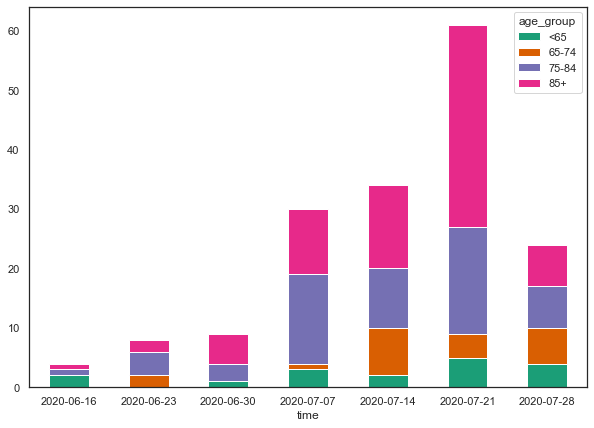

In [73]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

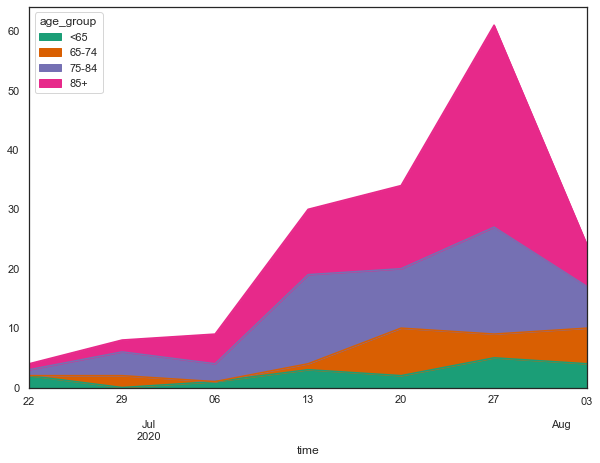

In [74]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

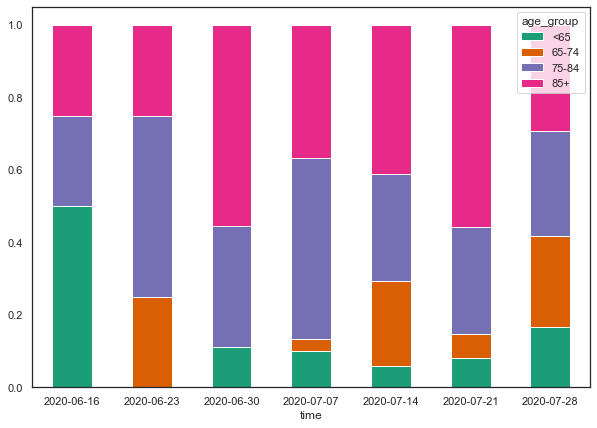

In [75]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [76]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


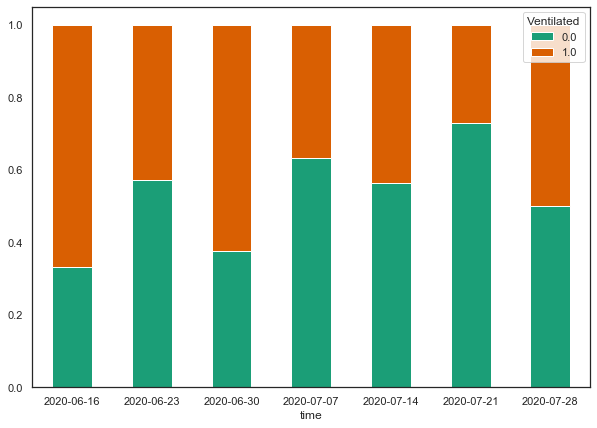

In [77]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

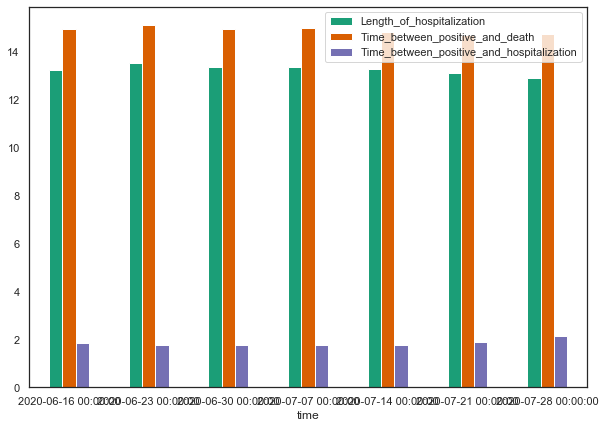

In [78]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


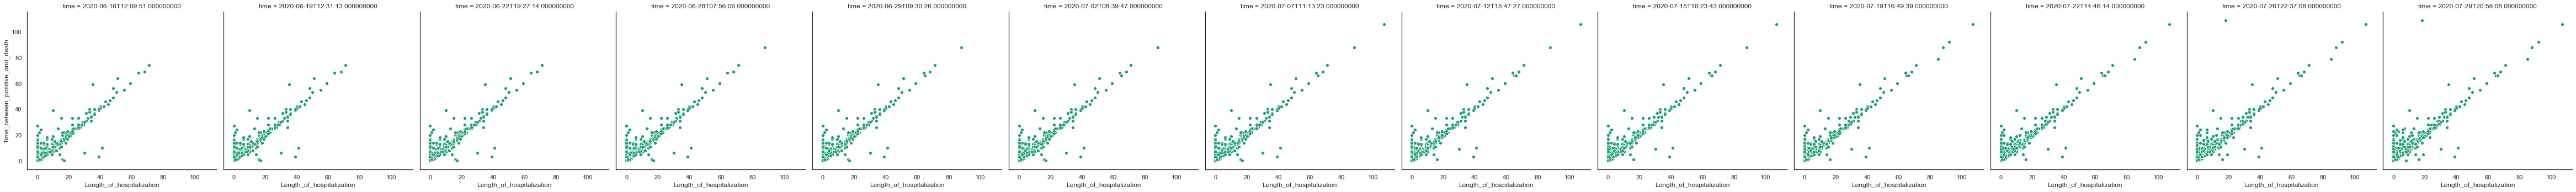

In [79]:
sns.relplot(data=decs, col='time', x='Length_of_hospitalization', y='Time_between_positive_and_death', kind='scatter')

In [80]:
hos.head().T

,0,1,2,3,4
date,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00
מאושפזים,75,97,115,153,192
אחוז נשים מאושפזות,36,39.2,39.1,41.2,44.3
גיל ממוצע מאושפזים,48,50,49,47,46
סטיית תקן גיל מאושפזים,17.4,18,18,18.3,18.6
resp,15,15,15,15,15
אחוז נשים מונשמות,20,20,20,0,20
גיל ממוצע מונשמים,63,63,63,70,74
סטיית תקן גיל מונשמים,15.3,15.3,15.3,7.4,7.6
חולים קל,68,90,105,144,178


In [81]:
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


## Recovered

In [82]:
pd.read_csv('data/corona_recovered_ver_004.csv.gz', encoding='1255')

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,8.0,9,40-49,נקבה,Contact with confirmed
1,19.0,9,30-39,זכר,Contact with confirmed
2,33.0,9,60+,זכר,Abroad
3,24.0,9,30-39,זכר,Contact with confirmed
4,20.0,9,40-49,זכר,Abroad
...,...,...,...,...,...
6408,NaN,NaN,60+,זכר,Other
6409,NaN,NaN,60+,נקבה,Contact with confirmed
6410,NaN,NaN,60+,נקבה,Contact with confirmed
6411,NaN,NaN,60+,זכר,Abroad


In [83]:
recs = []
for file in sorted(glob.glob('data/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

data\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
data\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
data\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
data\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
data\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
data\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
data\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
data\corona_recovered_ver_0025.csv.gz 2020-07-02 08:39:47
data\corona_recovered_ver_0026.csv.gz 2020-07-07 11:13:23
data\corona_recovered_ver_0031.csv.gz 2020-07-12 15:47:27
data\corona_recover

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication,time,file,ver
4923,12.0,3,30-39,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4281,15.0,3,40-49,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4280,4.0,3,20-29,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4279,13.0,3,50-59,זכר,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4278,7.0,3,30-39,נקבה,Abroad,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4


In [84]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

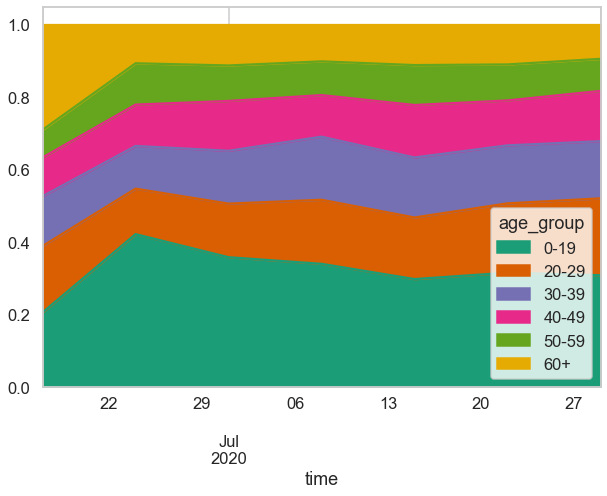

In [85]:
sns.set_style('whitegrid')
sns.set_context('talk')
rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [86]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='data', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

,first_week_day,last_week_day,age_group,gender,weekly_tests_num,weekly_newly_tested,weekly_cases,weekly_deceased
0,2020-03-15,2020-03-21,0-19,לא ידוע,44.0,44.0,0.0,0.0
1,2020-03-15,2020-03-21,0-19,זכר,1108.0,1051.0,40.0,0.0
2,2020-03-15,2020-03-21,0-19,נקבה,925.0,888.0,41.0,0.0
3,2020-03-15,2020-03-21,20-24,זכר,686.0,640.0,107.0,0.0
4,2020-03-15,2020-03-21,20-24,נקבה,641.0,620.0,39.0,0.0


In [87]:
ag.weekly_deceased.value_counts()

0.0     711
<15     137
26.0      2
15.0      2
19.0      1
16.0      1
28.0      1
Name: weekly_deceased, dtype: int64

In [88]:
ag.weekly_deceased.replace('<15','10').astype(int).plot()

ValueError: invalid literal for int() with base 10: '0.0'